In [34]:
import json
import pandas as pd
from sentence_transformers import SentenceTransformer
from itertools import product, combinations
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os

In [35]:
# Reload pickles

with open("frames-llama.pkl", "rb") as f:
    frames = pickle.load(f)
with open("newframes-llama.pkl", "rb") as f:
    newframes = pickle.load(f)


In [36]:
print(newframes["toys_male_female_none"])

    age  response-cosine-distance  followup-cosine-distance  \
0     3                  0.339489                  0.279222   
1     4                  0.342276                  0.225303   
2     5                  0.385339                  0.238394   
3     6                  0.353979                  0.199779   
4     7                  0.353214                  0.293672   
5     8                  0.387486                  0.258200   
6     9                  0.339452                  0.198741   
7    10                  0.339452                  0.219241   
8    11                  0.354421                  0.204824   
9    12                  0.339046                  0.195095   
10   13                  0.468855                  0.347137   
11   14                  0.468855                  0.258251   
12   15                  0.503167                  0.261153   

                                  response-diffvector  \
0   [-0.030813871, -0.039822076, 0.0022463351, 0.0...   
1  

In [37]:
def plot_bias_over_age(newframes, category, role="none", metric="response"):
    """
    Plot cosine-distance vs age for gender-pair comparisons in a given category.

    Parameters:
        newframes : dict
            Dictionary of DataFrames e.g. newframes["hobbies_male_female_none"]
        category : str
            e.g. "hobbies", "toys", "careers", "academics"
        role : str
            Usually "none", but flexible
        metric : str
            "response"  → use column "response-cosine-distance"
            "followup"  → use column "followup-cosine-distance"
    """

    # Decide which column to use based on metric selection
    column_map = {
        "response": "response-cosine-distance",
        "followup": "followup-cosine-distance"
    }

    if metric not in column_map:
        raise ValueError(f"metric must be 'response' or 'followup', but got: {metric}")

    dist_col = column_map[metric]

    gender_pairs = ["male_female", "male_child", "female_child"]
    colors = ["C0", "C1", "C2"]

    plt.figure(figsize=(10, 6))

    for pair, color in zip(gender_pairs, colors):
        key = f"{category}_{pair}_{role}"

        if key not in newframes:
            print(f"Warning: {key} not found in newframes.")
            continue

        df = newframes[key].copy()

        # Require age and the selected distance column
        if "age" not in df or dist_col not in df:
            print(f"Warning: missing 'age' or '{dist_col}' in {key}.")
            continue

        df = df.sort_values("age")

        plt.plot(
            df["age"],
            df[dist_col],
            marker="o",
            color=color,
            label=pair.replace("_", " vs. ")
        )

    pretty_metric = "Response" if metric == "response" else "Follow-Up"

    plt.xlabel("Age")
    plt.ylabel(f"{pretty_metric} Cosine Distance")
    plt.title(f"{pretty_metric} Bias vs Age — {category.capitalize()}, Role: {role.capitalize()} (LLaMA)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()

    
    directory = "plots-llama"
    os.makedirs(directory, exist_ok=True)

    name = f"{category}_{role}_{metric}"
    filename = os.path.join(directory, f"{name}.png")
    
    plt.savefig(filename, dpi=300, format='png')
    plt.close()

In [38]:
categories = ["toys", "hobbies", "careers", "academics"]
metrics = ["response", "followup"]
roles = ["none", "educator"]

for c, r, m in product(categories, roles, metrics):
    plot_bias_over_age(newframes, category=c, role=r, metric=m)


In [39]:
def build_pca_matrix(newframes, category, role="none", metric="response"):
    """
    Build an (N x D) matrix X for PCA from precomputed difference vectors
    stored in `newframes`.

    Assumes:
      - keys: f"{category}_{pair}_{role}", where pair is like "male_female"
      - each newframes[key] has columns: "age" and a diff column
      - diff column names:
            metric="response" -> "response-diff"
            metric="followup" -> "followup-diff"
    """
    # Map metric name to column name holding the diff vectors
    diff_col_map = {
        "response": "response-diffvector",
        "followup": "followup-diffvector",
    }
    if metric not in diff_col_map:
        raise ValueError("metric must be 'response' or 'followup'")
    diff_col = diff_col_map[metric]

    gender_pairs = ["male_female", "male_child", "female_child"]

    rows = []   # list of np.array diff vectors
    meta = []   # list of dicts with age/pair/category info

    for pair in gender_pairs:
        key = f"{category}_{pair}_{role}"
        if key not in newframes:
            print(f"Warning: {key} not found in newframes, skipping.")
            continue

        df = newframes[key]

        if diff_col not in df.columns:
            print(f"Warning: column '{diff_col}' not in {key}, skipping.")
            continue
        if "age" not in df.columns:
            print(f"Warning: column 'age' not in {key}, skipping.")
            continue

        # Each row is one sample for PCA
        for _, row in df.iterrows():
            diff_vec = row[diff_col]   # should be a 1D np.array
            rows.append(diff_vec)
            meta.append({
                "age": row["age"],
                "pair": pair,
                "category": category,
            })

    # Stack into an (N x D) matrix
    X = np.vstack(rows)   # shape: (num_samples, embedding_dim)
    meta_df = pd.DataFrame(meta)
    return X, meta_df

In [40]:
def run_pca(X, n_components=2):
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(X)  # shape: (N, n_components)
    return pca, components

In [41]:
def plot_pca_components(components, meta, explained_variance_ratio, role, metric):
    """
    components: array of shape (N, 2)
    meta: DataFrame with columns 'age', 'pair', 'category'
    explained_variance_ratio: array-like, e.g. pca.explained_variance_ratio_
                              (at least length 2)
    """
    ages = meta["age"].values
    pairs = meta["pair"].values
    category = meta["category"].values[0]

    # Build axis labels, with variance info if provided
    if explained_variance_ratio is not None and len(explained_variance_ratio) >= 2:
        pc1_var = explained_variance_ratio[0] * 100
        pc2_var = explained_variance_ratio[1] * 100
        xlabel = f"PC1 ({pc1_var:.1f}% variance)"
        ylabel = f"PC2 ({pc2_var:.1f}% variance)"
        subtitle = f"PC1+PC2 = {pc1_var + pc2_var:.1f}% total variance"
    else:
        xlabel = "PC1"
        ylabel = "PC2"
        subtitle = None

    plt.figure(figsize=(10, 7))

    markers = {
        "male_female": "o",
        "male_child": "s",
        "female_child": "^",
    }

    for pair, marker in markers.items():
        mask = (pairs == pair)
        if not mask.any():
            continue
        plt.scatter(
            components[mask, 0],
            components[mask, 1],
            c=ages[mask],
            cmap="viridis",
            s=80,
            marker=marker,
            label=pair.replace("_", " vs. "),
            edgecolors="k",
            alpha=0.8,
        )

    plt.colorbar(label="Age")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    title = f"PCA of Gender Difference Vectors: {category}-{role}-{metric} (LLaMA)"
    if subtitle is not None:
        plt.title(f"{title}\n{subtitle}")
    else:
        plt.title(title)

    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()

    directory = "plots-llama"
    os.makedirs(directory, exist_ok=True)

    name = f"PCA_{category}_{role}_{metric}"
    filename = os.path.join(directory, f"{name}.png")
    
    plt.savefig(filename, dpi=300, format='png')
    plt.close()
    #plt.show()

In [42]:
def gen_pca_figures(category, role="none", metric="response"):
    X, meta = build_pca_matrix(
        newframes,
        category=category,      # or "hobbies", etc.
        role=role,
        metric=metric     # or "followup"
    )

    pca, components = run_pca(X, n_components=3)
    #print("Explained variance ratio:", pca.explained_variance_ratio_)

    plot_pca_components(components, meta, pca.explained_variance_ratio_, role, metric)

In [43]:
for c, r, m in product(categories, roles, metrics):
    gen_pca_figures(category=c, role=r, metric=m)

#gen_pca_figures(category="toys", role="none", metric="response")

In [44]:
plt.scatter(meta['age'], components[:, 2])

NameError: name 'meta' is not defined

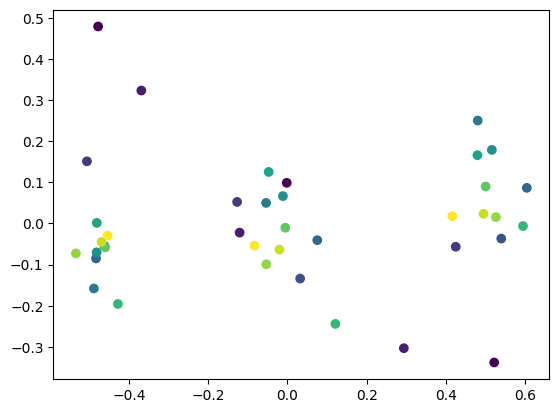

In [ ]:
plt.scatter(components[:, 0], components[:, 2], c=meta['age'])


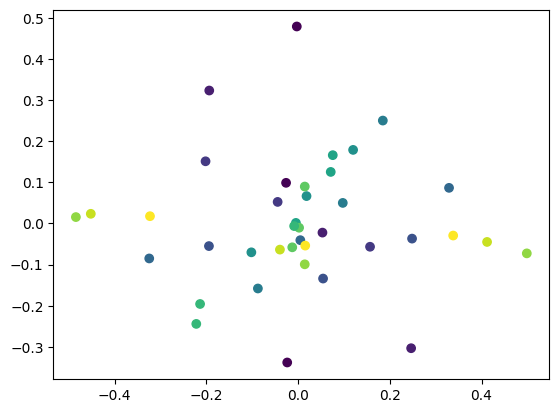

In [ ]:
plt.scatter(components[:, 1], components[:, 2], c=meta['age'])